In [1]:
# imports
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import seaborn as sns

In [2]:
# Loading dataset
# path_df = r'C:\Users\91951\Downloads\dataset.csv'
df = pd.read_csv('dataset.csv')

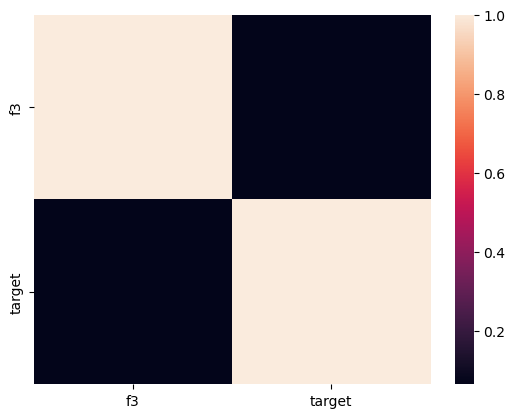

In [7]:

sns.heatmap(df.corr())
plt.show()

In [8]:
df.isna().sum()  # No empty cells

f1        0
f2        0
f3        0
f4        0
f5        0
f6        0
f7        0
target    0
dtype: int64

In [9]:
df.duplicated().sum()  # No duplicates

0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   f1      766 non-null    object
 1   f2      766 non-null    object
 2   f3      766 non-null    int64 
 3   f4      766 non-null    object
 4   f5      766 non-null    object
 5   f6      766 non-null    object
 6   f7      766 non-null    object
 7   target  766 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 48.0+ KB


In [11]:
df.apply(lambda x: pd.to_numeric(x, errors='coerce')).isna().sum()  #we can drop Na values or just replace them with mean of the column data

f1        1
f2        1
f3        0
f4        1
f5        1
f6        1
f7        1
target    0
dtype: int64

In [12]:
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()  #3 rows dropped

from sklearn.preprocessing import MinMaxScaler  # useless

In [13]:
X = df.drop('target', axis=1).values
y = df.target
# print(X.dtypes)
# print(y.dtypes)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(type(X_train),type(X_test),type(y_train),type(y_test))

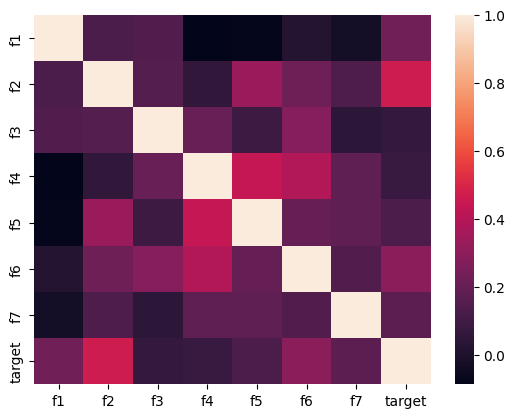

In [218]:
sns.heatmap(df.corr())
plt.show()

In [14]:
X_train

array([[ 0.94148548,  0.25092826, -0.05761952, ...,  0.38756454,
         0.8235221 , -0.10314457],
       [ 0.34669831,  1.15711521,  0.04529666, ..., -0.69463614,
        -0.27850747, -0.80181728],
       [-1.14026962,  0.5321587 , -3.55676965, ..., -0.69463614,
         0.54484796,  1.38454646],
       ...,
       [ 1.83366624, -0.62401086,  0.8686261 , ..., -0.69463614,
         1.72287957,  1.99588508],
       [-1.14026962,  0.62590217, -3.55676965, ..., -0.69463614,
         1.31753536, -0.80784032],
       [-1.14026962,  0.12593696,  1.38320701, ..., -0.69463614,
        -1.20319896, -0.63618367]])

# Base model

In [15]:
import torch.nn as nn

class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ReLU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ReLU()          # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.activation2(self.hidden_layer1(x))
        x = self.activation2(self.hidden_layer2(x))
        x = self.activation3(self.hidden_layer3(x))
        return x

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

# Save the model weights
torch.save(model.state_dict(), 'sungjun_abhinav_assignment2_part1.h5')

Test Accuracy: 0.7368


# Dropouts  // model1, model2, model3


In [17]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self,dropout):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(dropout)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ReLU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ReLU()          # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
# model_1 = SimpleBinaryClassifier()
# criterion = nn.BCELoss()
# optimizer = optim.SGD(model_1.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam
dropout_rate = [0.1,0.3,0.5]

for dropout in dropout_rate:
    model_1 = SimpleBinaryClassifier(dropout)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model_1.parameters(), lr=0.01)  
# Train the model
    epochs = 50
    for epoch in range(epochs):
        model_1.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model_1(inputs)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Print training loss at each epoch
        # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_1.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_1(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.7500
Test Accuracy: 0.7566
Test Accuracy: 0.7697


In [ ]:
# Save the model weights
torch.save(model_1.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Activation Function - LeakyRelu
# Model_4

In [144]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.LeakyReLU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.LeakyReLU()         # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_4 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
for epoch in range(epochs):
    model_4.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_4(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_4.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_4(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.7763


In [145]:
# Save the model weights
torch.save(model_4.state_dict(), r'sungjun_abhinav_assignment2_part2.h5')

# Activation Function - Tanh
# Model_5

In [147]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.Tanh()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.Tanh()         # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_5 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_5.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
for epoch in range(epochs):
    model_5.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_5(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_5.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_5(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.7500


In [ ]:
# Save the model weights
torch.save(model_5.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Activation Function - ELU
# Model_6

In [212]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_6 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_6.parameters(), lr=0.01)  

# Train the model
epochs = 50
for epoch in range(epochs):
    model_6.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_6(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_6.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_6(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.7368


In [75]:
# Save the model weights
torch.save(model_6.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Optimizer Adams
# Model_7

In [153]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_7 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_7.parameters(),lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model_7.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_7(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_7.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_7(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.7368


In [ ]:
# Save the model weights
torch.save(model_7.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Optimizer - Adagrad
# Model_8

In [209]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_8 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adagrad(params=model_8.parameters(),lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model_8.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_8(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_8.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_8(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.7434


In [85]:
# Save the model weights
torch.save(model_8.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Optimizer - RMSPROP
# Model_9

In [208]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_9 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.RMSprop(params=model_9.parameters(),lr=0.1)

# Train the model
epochs = 50
for epoch in range(epochs):
    model_9.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_9(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_9.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_9(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.7303


In [91]:
# Save the model weights
torch.save(model_9.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Initializer - Kaiming Initialization 
# Model_10

In [168]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.kaiming_normal_(self.input_layer.weight)
        nn.init.kaiming_normal_(self.hidden_layer1.weight)
        nn.init.kaiming_normal_(self.hidden_layer2.weight)
        nn.init.kaiming_normal_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_10 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_10.parameters(),lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model_10.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_10(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_10.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_10(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.7566


In [94]:
# Save the model weights
torch.save(model_10.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Initializer - weights zeros
# Model_11

In [204]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.zeros_(self.input_layer.weight)
        nn.init.zeros_(self.hidden_layer1.weight)
        nn.init.zeros_(self.hidden_layer2.weight)
        nn.init.zeros_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_11 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_11.parameters(),lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model_11.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_11(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_11.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_11(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.7434


In [96]:
# Save the model weights
torch.save(model_11.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Initializer - xavier
# Model_12

In [179]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_12 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_12.parameters(),lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model_12.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_12(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_12.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_12(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7566


In [101]:
# Save the model weights
torch.save(model_12.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Gradient clipping 
# Model_13

In [182]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_13 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_13.parameters(),lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model_13.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_13(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #gradient clipping 
        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_13.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_13(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7566


In [103]:
# Save the model weights
torch.save(model_13.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Batch Normalization 
# Model_14

In [186]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.batch1 = nn.BatchNorm1d(128)
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.batch2 = nn.BatchNorm1d(128)
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.batch3 = nn.BatchNorm1d(64)
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.batch1(x)
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.batch2(x)
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.batch3(x)
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_14 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_14.parameters(),lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model_14.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_14(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #gradient clipping 

        optimizer.step()
        running_loss += loss.item()
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_14.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_14(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7632


In [107]:
# Save the model weights
torch.save(model_14.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Learning rate scheduler
# Model_15

In [189]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_15 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_15.parameters(),lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5) #scheduler call

# Train the model
epochs = 50
for epoch in range(epochs):
    model_15.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_15(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #gradient clipping 

        optimizer.step()
        running_loss += loss.item()
        scheduler.step(loss)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
with torch.no_grad():
    model_15.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_15(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7763


In [191]:
# Save the model weights
torch.save(model_15.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# cyclic Learning rate scheduler
# Model_16

In [200]:
from torch.optim.lr_scheduler import CyclicLR

class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


model_16 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(params=model_16.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, mode='triangular')

# Train the model
epochs = 50
for epoch in range(epochs):
    model_16.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_16(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        scheduler.step(loss)
    
  

# Evaluate the model on test data
with torch.no_grad():
    model_16.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model_16(inputs)
        predicted_labels = (outputs >= 0.5).int()
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7500


In [124]:
# Save the model weights
torch.save(model_16.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Graph

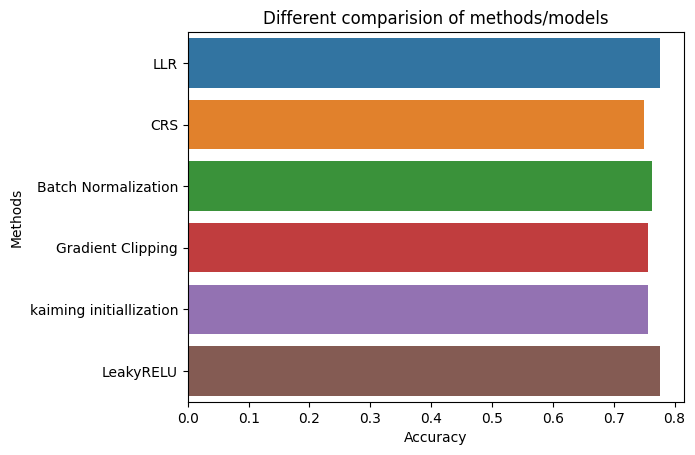

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_list = [0.7763,0.75,0.7632,0.7566,0.7566,0.7763]
names_list = ["LLR","CRS","Batch Normalization","Gradient Clipping","kaiming initiallization","LeakyRELU"]

sns.barplot(y=names_list,x=acc_list)
sns.color_palette("pastel")
plt.xlabel("Accuracy")
plt.ylabel("Methods")
plt.title("Different comparision of methods/models")
plt.show()